### Attempt to use an ANN to classify images from the MNIST dataset

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Load in MNIST data
Grab MNIST image files and convert them to tensors

In [6]:
# Grab train and test sets
train_data = datasets.MNIST('../Data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../Data', train=False, download=True, transform=transforms.ToTensor())

train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
# Explore first record of dataset
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [11]:
# Explore size of an image tensor
image,label = train_data[0]
image.shape
# The "1" represents a single color channel, since we have a grayscale image

torch.Size([1, 28, 28])

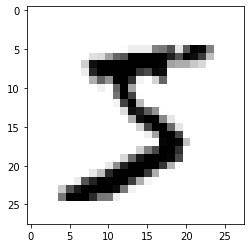

In [15]:
# Visualize image
plt.imshow(image.reshape(28,28), cmap='gist_yarg')

In [18]:
# Load in batches with data loader
# shuffle=True since some datasets are ordered. We don't want to train on batches of all 0s, then switch to 1s suddenly and have the model struggle to learn. Data is shuffled after each epoch
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
# Larger batch size for test set since we are only predicting. We don't care if the test data is shuffled or not
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [19]:
# Grab a batch of images to visualize
from torchvision.utils import make_grid
for imgs,lbls in train_loader:
    break
imgs.shape  # Just grab the first batch
# # imgs, color channel, width, height

torch.Size([100, 1, 28, 28])

Labels:  [3 4 1 8 1 1 1 1 1 4 9 0]


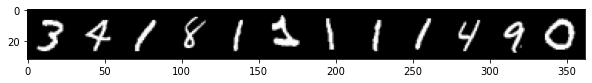

In [25]:
# Print the first 12 labels
print('Labels: ', lbls[:12].numpy())

# Show the first 12 images
im = make_grid(imgs[:12], nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))  # transpose images from CWH to WHC (Width, Height, Color channel)

### Build model
We will build a multilayer perceptron model

In [60]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        # Instantiate nn.Module
        super().__init__()
        # Build layers
        self.fc1 = nn.Linear(in_sz, layers[0])  # Build fully connected layer 1
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self, X):
        # Pass features thru layers and activation fns
        X = F.relu(self.fc1(X))  # rectified linear unit activation
        X = F.relu(self.fc2(X))  # rectified linear unit activation
        X = self.fc3(X)  # 
        return F.log_softmax(X, dim=1)  # dim indicates axis to perform log_softmax on

In [61]:
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [62]:
# Define loss fn and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [63]:
# Flatten out image data
imgs.shape  # ----> [100,784]

torch.Size([100, 1, 28, 28])

In [64]:
imgs.view(100,-1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### Train the model

In [65]:
import time
start = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    # train_loader loads training data in shuffled batches of size 100 (as specified above). It is a generator of the "DataLoader" class
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1  # start batches at 1
        # Predictions on flattened training data
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)
        # Track correct preds for each batch, then update trn_corr
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        # Update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print results during training
        if b%200 == 0:
            accuracy = trn_corr.item()/b
            print(f'Epoch {i} batch {b} loss: {loss.item()} accuracy: {accuracy}')
    # Update training metrics
    train_losses.append(loss)
    train_correct.append(trn_corr)
    # Run test data during training - understand how test val is going down. This helps us combat overfitting
    with torch.no_grad():  # don't update weights/biases with test data
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500,-1))  # flatten test data, batch sz = 500
            predicted = torch.max(y_val.data,1)[1]  # get max value from prediction data tensor with length of 10 (0-9)
            tst_corr += (predicted == y_test).sum()
    # Update test loss and accuracy for entire epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

elapsed = time.time() - start
print(f'Training time took {round(elapsed/60, 2)} minutes!')

Epoch 0 batch 200 loss: 0.212547168135643 accuracy: 82.8
Epoch 0 batch 400 loss: 0.23726417124271393 accuracy: 87.345
Epoch 0 batch 600 loss: 0.19078922271728516 accuracy: 89.38
Epoch 1 batch 200 loss: 0.11991140246391296 accuracy: 94.965
Epoch 1 batch 400 loss: 0.19738422334194183 accuracy: 95.1775
Epoch 1 batch 600 loss: 0.13182522356510162 accuracy: 95.385
Epoch 2 batch 200 loss: 0.10574991255998611 accuracy: 96.68
Epoch 2 batch 400 loss: 0.0989854633808136 accuracy: 96.645
Epoch 2 batch 600 loss: 0.10110487043857574 accuracy: 96.78
Epoch 3 batch 200 loss: 0.046587325632572174 accuracy: 97.355
Epoch 3 batch 400 loss: 0.036438215523958206 accuracy: 97.49
Epoch 3 batch 600 loss: 0.08356725424528122 accuracy: 97.47
Epoch 4 batch 200 loss: 0.08087991923093796 accuracy: 97.975
Epoch 4 batch 400 loss: 0.09306145459413528 accuracy: 97.925
Epoch 4 batch 600 loss: 0.08099005371332169 accuracy: 97.96166666666667
Epoch 5 batch 200 loss: 0.02335907518863678 accuracy: 98.465
Epoch 5 batch 400 lo

### Visualize loss and accuracy
See loss and accuracy on both training and test data

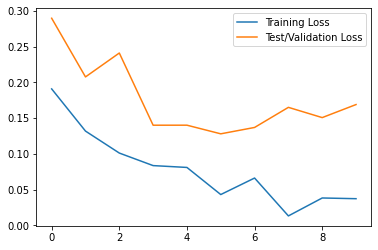

In [69]:
# Training losses
plt.plot([el.item() for el in train_losses], label='Training Loss')
# Test losses
plt.plot([el.item() for el in test_losses], label='Test/Validation Loss')
plt.legend()

In [71]:
# Accuracy
# Each tensor represents the # of training vals predicted correctly (out of 60000)
train_correct

[tensor(53628),
 tensor(57231),
 tensor(58068),
 tensor(58482),
 tensor(58777),
 tensor(59011),
 tensor(59167),
 tensor(59329),
 tensor(59460),
 tensor(59532)]

In [72]:
# divide test accuracy elements by 100 for pct since test_data has 10000 elements
test_correct

[tensor(9447),
 tensor(9585),
 tensor(9618),
 tensor(9707),
 tensor(9732),
 tensor(9746),
 tensor(9747),
 tensor(9732),
 tensor(9732),
 tensor(9746)]

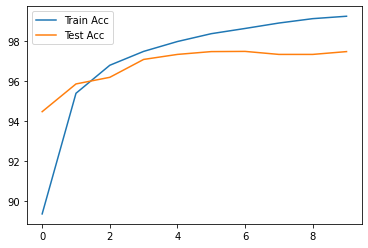

In [76]:
trn_acc = [el.item()/600 for el in train_correct]
tst_acc = [el.item()/100 for el in test_correct]
plt.plot(trn_acc, label='Train Acc')
plt.plot(tst_acc, label='Test Acc')
plt.legend()
# Beyond 4 epochs or so, we begin to overfit to the training data since the test accuracy has nearly flattened out

### Predictions on new, unseen data

In [87]:
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_val = model(X_test.view(len(X_test),-1))  # flatten out images in x_test
        pred = torch.max(y_val, 1)[1]
        correct += (pred == y_test).sum()

In [90]:
round(correct.item()/len(test_data)*100,2)

97.46

In [96]:
confusion_matrix(pred, y_test)

array([[ 971,    0,    5,    0,    0,    2,    6,    0,    3,    2],
       [   0, 1118,    0,    0,    0,    1,    2,    5,    0,    4],
       [   0,    4, 1011,    9,    5,    0,    2,   10,    3,    0],
       [   0,    0,    2,  966,    1,    7,    1,    2,    1,    4],
       [   1,    0,    1,    0,  956,    0,   11,    2,    1,    9],
       [   1,    1,    0,   12,    2,  869,    7,    0,    5,    4],
       [   1,    1,    1,    0,    3,    6,  928,    0,    1,    0],
       [   1,    1,    3,    5,    2,    1,    0,  995,    2,    2],
       [   4,   10,    9,   11,    1,    2,    1,    4,  953,    5],
       [   1,    0,    0,    7,   12,    4,    0,   10,    5,  979]],
      dtype=int64)